Here, we  will create some simulated datasets to benchmark Pearson, Spearman and mmvec.

First we'll need to import simulation code.

In [1]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
from biom.util import biom_open
from src.generators import (
    deposit, deposit_biofilms, random_biofilm, ground_truth_edges
)
from src.sim import cystic_fibrosis_simulation
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
%matplotlib inline

Now we will want to specify some of the simulation parameters.

In [2]:
#### simulation parameters
np.random.seed(0)
num_metabolites = 100
num_microbes = 100
#num_samples = 126

# mean of U prior
uU = 0 
# variance of U prior
sigmaU = 1
# mean of V prior
uV = 0
# variance of V prior
sigmaV = 1
# number of latent dimensions
latent_dim = 3
# variance of microbe error distribution
sigmaQ = 1
# microbe total count
microbe_total = 5e3
# metabolite total count
metabolite_total = 1e9
# dispersion parameter for total counts
microbe_tau = 0.1
# dispersion parameter for total intensities
metabolite_tau = 0.1
# dispersion parameter for microbe abundances
microbe_kappa = 0.1
# dispersion parameter for metabolite abundances
metabolite_kappa = 0.1
# parameter for exponential distribution of microbes
microbe_rate = 0.5

# bounds to evaluate for simulation
min_time = 0
# everything past timepoint 9 involves antibiotic treatment.
max_time = 10
# bounds for y coordinates
min_y = 0
max_y = 20
seed = None

sample_ids = [0]
choice = 'abcdefghijklmnopqrstuvwxyz'
modes = ['abs', 'rel']

# retrieve absolute abundances and perform cutoffs
df = cystic_fibrosis_simulation('../data/cf_sim')
table = df.loc[
    np.logical_and(
        np.logical_and(
            df.y >= min_y, df.y <= max_y
        ),
        np.logical_and(
            df.time >= min_time, df.time < max_time
        )
    )
]

In [3]:
 res = random_biofilm(table,
                      uU=uU, sigmaU=sigmaU, uV=uV, sigmaV=sigmaV,
                      sigmaQ=sigmaQ, latent_dim=latent_dim,
                      num_microbes=num_microbes,
                      num_metabolites=num_metabolites,
                      microbe_total=microbe_total,
                      microbe_kappa=microbe_kappa,
                      microbe_tau=microbe_tau,
                      metabolite_total=metabolite_total,
                      metabolite_kappa=metabolite_kappa,
                      metabolite_tau=metabolite_tau,
                      microbe_rate=microbe_rate,
                      seed=seed)

(edges,abs_microbe_counts, abs_metabolite_counts, rel_microbe_counts, rel_metabolite_counts) = res

/Users/jmorton/Dropbox (Simons Foundation)/multiomics/multiomic-cooccurences/ipynb/src/generators.py:612: RuntimeWarning: divide by zero encountered in log
  y = state.lognormal(np.log(n*p), metabolite_kappa)


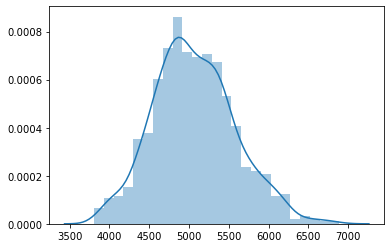

In [4]:
sns.distplot(rel_microbe_counts.sum(axis=1))

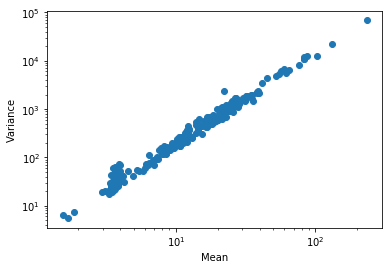

In [5]:
plt.scatter(rel_microbe_counts.mean(axis=0), rel_microbe_counts.var(axis=0))
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.xscale('log')
plt.yscale('log')

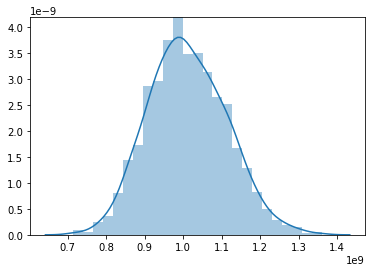

In [6]:
sns.distplot(rel_metabolite_counts.sum(axis=1))

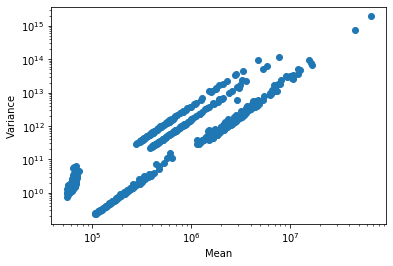

In [7]:
plt.scatter(rel_metabolite_counts.mean(axis=0), rel_metabolite_counts.var(axis=0))
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.xscale('log')
plt.yscale('log')

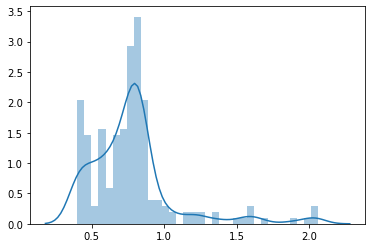

In [8]:
sns.distplot(abs_microbe_counts.sum(axis=1))

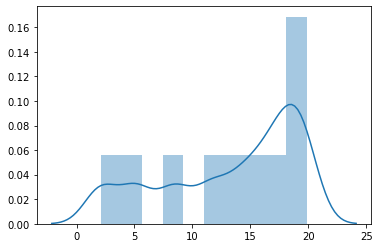

In [9]:
sns.distplot(abs_metabolite_counts.sum(axis=1))

In [10]:
theta_f = list(map(lambda i: 'theta_f_%d' % i, range(num_microbes)))
theta_p = list(map(lambda i: 'theta_p_%d' % i, range(num_microbes)))
F = list(map(lambda i: 'F_%d' % i, range(num_metabolites)))
P = list(map(lambda i: 'P_%d' % i, range(num_metabolites)))
I = list(map(lambda i: 'I_%d' % i, range(num_metabolites)))
SA = list(map(lambda i: 'SA_%d' % i, range(num_metabolites)))
SG = list(map(lambda i: 'SG_%d' % i, range(num_metabolites)))

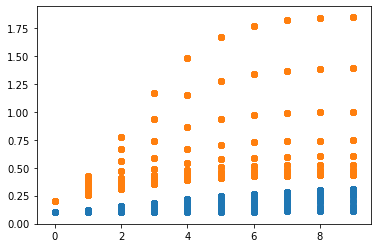

In [11]:
plt.scatter(table.time, abs_microbe_counts[theta_f].sum(axis=1))
plt.scatter(table.time, abs_microbe_counts[theta_p].sum(axis=1))

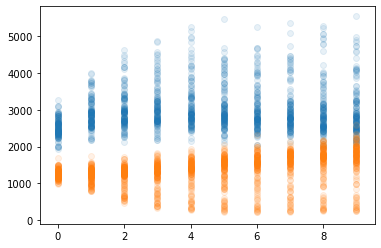

In [12]:
plt.scatter(table.time, rel_microbe_counts[theta_p].sum(axis=1), alpha=0.1)
plt.scatter(table.time, rel_microbe_counts[theta_f].sum(axis=1), alpha=0.1)

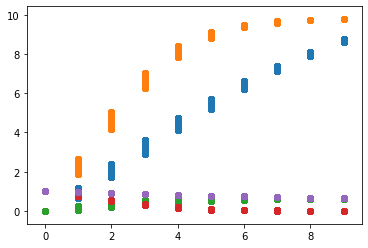

In [13]:
plt.scatter(table.time, abs_metabolite_counts[F].sum(axis=1), label='F')
plt.scatter(table.time, abs_metabolite_counts[P].sum(axis=1), label='P')
plt.scatter(table.time, abs_metabolite_counts[I].sum(axis=1), label='I')
plt.scatter(table.time, abs_metabolite_counts[SA].sum(axis=1), label='SA')
plt.scatter(table.time, abs_metabolite_counts[SG].sum(axis=1), label='SG')

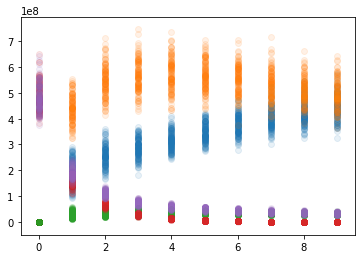

In [14]:
plt.scatter(table.time, rel_metabolite_counts[F].sum(axis=1), label='F', alpha=0.1)
plt.scatter(table.time, rel_metabolite_counts[P].sum(axis=1), label='P', alpha=0.1)
plt.scatter(table.time, rel_metabolite_counts[I].sum(axis=1), label='I', alpha=0.1)
plt.scatter(table.time, rel_metabolite_counts[SA].sum(axis=1), label='SA', alpha=0.1)
plt.scatter(table.time, rel_metabolite_counts[SG].sum(axis=1), label='SG', alpha=0.1)

In [15]:
idx = np.random.permutation(np.arange(abs_microbe_counts.shape[0]))

In [16]:
abs_microbe_counts = abs_microbe_counts.iloc[idx]
rel_microbe_counts = rel_microbe_counts.iloc[idx]

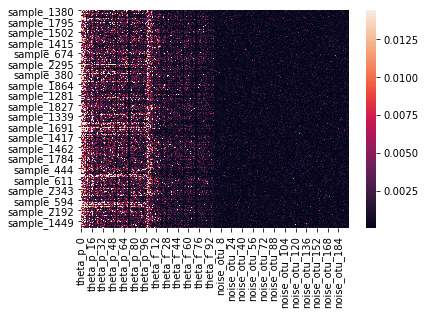

In [17]:
sns.heatmap(abs_microbe_counts, robust=True)

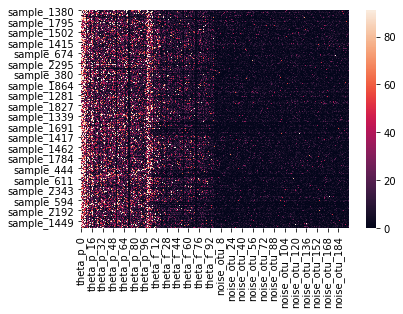

In [18]:
sns.heatmap(rel_microbe_counts, robust=True)

In [19]:
metadata = df.iloc[idx]
metadata['Testing'] = ['Test'] * 100 + ['Train'] * (metadata.shape[0] - 100)

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
np.sum((rel_microbe_counts>0).values)

436234

In [21]:
rel_microbe_counts.shape[0] * rel_microbe_counts.shape[1]

504000

In [22]:
np.sum((rel_metabolite_counts>0).values)

844200

In [23]:
rel_metabolite_counts.shape[0] * rel_metabolite_counts.shape[1]

882000

Save the simulate biofilms into a folder and save the config file

In [24]:
!mkdir ../results/CF_small_benchmark

mkdir: ../results/CF_small_benchmark: File exists


In [25]:
output_dir='../results/CF_small_benchmark'
deposit_biofilms(output_dir=output_dir,
                 abs_table1=abs_microbe_counts,
                 abs_table2=abs_metabolite_counts,
                 rel_table1=rel_microbe_counts,
                 rel_table2=rel_metabolite_counts,
                 edges=edges,
                 metadata=metadata,
                 sample_id=0
)

In [26]:
# generate config file
config_file = os.path.join(output_dir, 'effect_size.yaml')
tools = ['mmvec', 'pearson', 'spearman']
modes = ['abs', 'rel']

data = {
    'benchmark': 'effect_size',
    'output_dir': output_dir,
    'samples': list(sample_ids),
    'tools': tools,
    'modes': modes,
    'min_y': min_y,
    'max_y': max_y,
    'min_time': min_time,
    'max_time': max_time,
    # parameters to simulate the model
    'num_microbes' : num_microbes,
    'num_metabolites' : num_metabolites,
    'microbe_total' : microbe_total,
    'metabolite_total' : metabolite_total,
    'latent_dim' : latent_dim,
    'sigmaQ' : sigmaQ,
    'uU' : uU,
    'sigmaU' : sigmaU,
    'uV' : uV,
    'sigmaV' : sigmaV
}
with open(config_file, 'w') as yfile:
    yaml.dump(data, yfile, default_flow_style=False)